<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/topic_modeling/Topic_Modeling_Summaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HHS OIG Workplan Topic Modeling
## Topic Modeling for OIG Reports
*Description: A look through the current OIG work projects and group them using LDA.*

## Specific Questions on Work Plan Reports
1) What does OIG cite as major focus areas (as topics)?  
- *How can we group OIG's work projects and products by topic?*

2) Do those topics line up with major focus areas that HHS OIG designates as their priority outcomes/ultimate goals? (from: https://oig.hhs.gov/documents/root/7/OIG-Strategic-Plan-2020-2025.pdf)


*HHS OIG: Outlined Goals and Priorities*
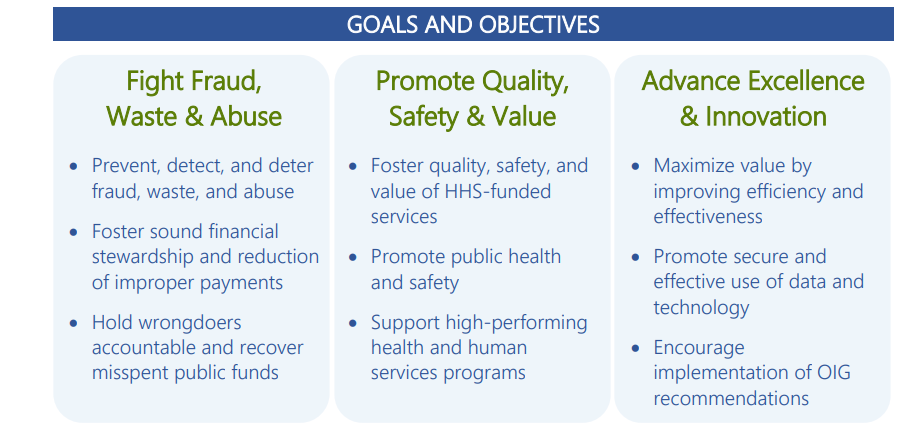

## Topic Models Used:
1) **Latent Dirichilet Allocation (LDA) Model**  
2) **BerTopic Model**


In [1]:
from IPython.display import clear_output

In [2]:
#Install missing packages
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]
!python -m spacy download en_core_web_md -qq
clear_output()

In [3]:
###########################
# Import Packages         #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords',
               'wordnet',
               'omw-1.4'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

clear_output()

In [4]:
###########################
# Load CSVs (Github)      #
###########################
reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [5]:
#Method to save LDA model to disk
'''
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

clear_output()

## Latent Dirichlet Allocation (LDA) Model
Topic model by cleaning text and running it through an LDA model.

In [26]:
reports_df.head()

,Unnamed: 0,Report Number(s),Workplan_Title,Workplan_Summary
0,0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...
1,1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...
2,2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...
3,3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...
4,4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...


In [30]:
reports_df.dropna(inplace = True)

## LDA Step 1: Parse, Clean, and Tokenize text
- Set stopwords, add custom stopwords
- Remove Punctuation, tokenize and stem data
- Set series of lists of tokens and count of tokens

In [31]:
###########################
# Text Cleaning           #
###########################
from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (Add additional stopwords that were high-frequency)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for specific/frequent hhs-related words
stopwords.extend(['oig',
                  'hhs',
                  'amp',
                  'asp'])

##############################
# Tokenize and Stemmer       #
##############################
#Set tokenizer as regex tokenizer to remove punctuation
regex_tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in reports_df["Workplan_Summary"]]

tokenized_sums = [[i for i in regex_tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
reports_df["summary_tokenized"] = tokenized_stemmed_sums

reports_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

## Model Score (Coherence)
- U_mass coherence score is a score of the frequency at which two words appear together. 
- Score Coherence of Model - u_mass coherence score
- (Consider also c_v, other scores)
See: https://www.baeldung.com/cs/topic-modeling-coherence-score

In [38]:
###############################
# LDA Data: Run LDA           #
###############################

dictionary = Dictionary(reports_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 50% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

#Corpus from doc2bow
corpus = [dictionary.doc2bow(doc) for 
          doc in reports_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=17,
                         workers = 8, 
                         passes=20)

In [39]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-1.879724557881985


In [35]:
#########################
# Test Number of Topics #
#########################
lda_umass_scores = []

for topic_num in range(1,30,4):
    #LDA model parameters
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=200, 
                            num_topics=topic_num,
                            workers = None, 
                            passes=10)

    #LDA Model Coherence Score
    cm = CoherenceModel(model=lda_model, 
                        corpus=corpus, 
                        coherence="u_mass")
    
    # get coherence value
    coherence = cm.get_coherence()  
    print(f"Topics:{topic_num}, Coherence = {coherence}")
    
    #Save Coherence Values
    lda_umass_scores.append([topic_num, coherence])

Topics:1, Coherence = -1.1480107429747295
Topics:5, Coherence = -2.630758304002493
Topics:9, Coherence = -1.9641310343000393
Topics:13, Coherence = -1.9720909377183122
Topics:17, Coherence = -1.804199119046444
Topics:21, Coherence = -1.923399392298679
Topics:25, Coherence = -1.7623664420098097
Topics:29, Coherence = -1.9269379017571528


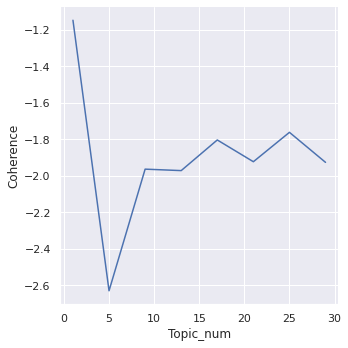

In [40]:
#Coherence Score Graphing
coherence_scores = pd.DataFrame(lda_umass_scores, 
                                columns = ['Topic_num',
                                           'Coherence'])

sns.relplot(data = coherence_scores, 
            kind="line",
            x = 'Topic_num', 
            y= 'Coherence')

### Run LDA
Using the cleaned data, run the LDA model on the summary tokens.
- Set dictionary as the tokens,
- Filter Extremes
- Set Corpus with Doc2bow
- Create LDA Model with Parameters

### Check Summaries
Let's take a look at how well the text parsing and tokenization worked

In [41]:
#Sample Summaries
sample_item = reports_df.sample(1)

print(sample_item["Workplan_Summary"].iloc[0])

print(sample_item["summary_tokenized"].iloc[0])

The Centers for Medicare &amp; Medicaid Services (CMS) reimburses Medicare contractors for a portion of their nonqualified plan costs., The Department of Health and Human Services, Office of Inspector General (OIG), Office of Audit Services, Region VII pension audit team reviews the cost elements related to qualified defined-benefit, postretirement benefit, and any other pension-related cost elements claimed by Medicare contractors through Incurred Cost Proposals (ICPs)., Previous OIG audits found that Medicare contractors did not always comply with Federal requirements when claiming nonqualified plan costs for Medicare reimbursement., Our objective was to determine whether the calendar years (CYs) 2015 and 2016 Blue Cross Blue Shield of South Carolina Excess Plan (Excess Plan) costs that CGS Administrators, LLC (CGS), claimed for Medicare reimbursement, and reported on its ICPs, were allowable and correctly claimed., We reviewed $351,277 of Excess Plan costs that CGS claimed for Medic

### LDA: Visualize and View Topics
*Use PyLDAvis to generate a visualization of the model*

#### Side Note: We may encounter the word 'Part' often in the data.

#### What are the 'parts' of medicare?
- https://www.medicareinteractive.org/get-answers/medicare-basics/medicare-coverage-overview/original-medicare
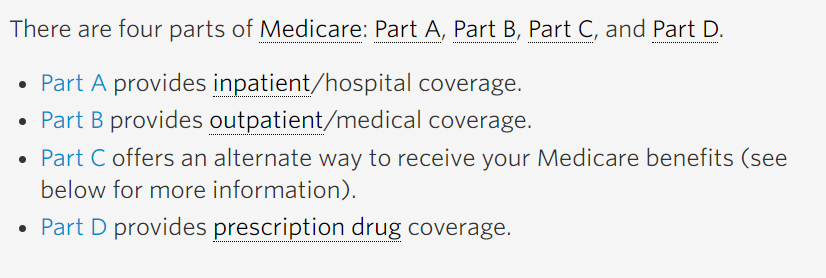

In [42]:
#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

#Give context and explanation for the lambda relevance metric

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.155725 -0.070963       1        1  12.755476
3     -0.093509  0.009091       2        1  10.631981
7      0.164884  0.037807       3        1  10.120647
8      0.143247 -0.025276       4        1   7.268709
15     0.081169  0.054107       5        1   6.852603
6      0.027092 -0.027429       6        1   6.331341
10    -0.105121 -0.190688       7        1   6.175422
12     0.125896  0.016149       8        1   5.749365
11     0.089183 -0.091031       9        1   5.233092
2     -0.003082  0.147786      10        1   5.113786
4     -0.327925  0.041417      11        1   4.392012
13     0.004125  0.176745      12        1   3.984248
1     -0.018424 -0.011698      13        1   3.711444
9      0.108395 -0.028732      14        1   3.498490
5     -0.033094 -0.066678      15        1   3.288896
16     0.041915 -0.164733      16        1   2.685132
0     -0.049026  0.194126      17        1   2.207357, topic_info=              Term         Freq        Total Category  logprob  loglift
301           cost   824.000000   824.000000  Default  30.0000  30.0000
757       hospital   634.000000   634.000000  Default  29.0000  29.0000
688           drug  1097.000000  1097.000000  Default  28.0000  28.0000
772     beneficiar   890.000000   890.000000  Default  27.0000  27.0000
79         payment  1385.000000  1385.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
128       addition    18.150025   238.291950  Topic17  -4.8467   1.2385
39   documentation    16.720693   314.760084  Topic17  -4.9287   0.8782
27         comment    16.456097   310.883819  Topic17  -4.9447   0.8747
127         action    16.493431   388.719229  Topic17  -4.9424   0.6535
358        general    14.595549   121.520159  Topic17  -5.0647   1.6940

[919 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
314       1  0.793433   100
314       4  0.020172   100
314       5  0.013448   100
314       6  0.114308   100
314       8  0.013448   100
...     ...       ...   ...
123       6  0.043911  york
123      12  0.047289  york
659       2  0.578610     ½
659       9  0.185982     ½
659      17  0.206646     ½

[4279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 4, 8, 9, 16, 7, 11, 13, 12, 3, 5, 14, 2, 10, 6, 17, 1])

In [43]:
#Topics Generated
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.061*"cdc" + 0.032*"audit" + 0.021*"control" + 0.020*"million" + 0.020*"disease" + 0.018*"recover" + 0.017*"fund" + 0.017*"period" + 0.016*"prevention" + 0.014*"prior"
Topic: 1 
Words: 0.059*"agency" + 0.043*"state" + 0.038*"code" + 0.031*"diagnosi" + 0.029*"risk" + 0.028*"provider" + 0.023*"error" + 0.019*"group" + 0.016*"comply" + 0.016*"home"
Topic: 2 
Words: 0.027*"audit" + 0.025*"nih" + 0.022*"order" + 0.021*"procedure" + 0.019*"award" + 0.017*"grant" + 0.016*"proces" + 0.016*"polic" + 0.015*"acf" + 0.015*"risk"
Topic: 3 
Words: 0.047*"payment" + 0.037*"new" + 0.030*"million" + 0.026*"state" + 0.024*"york" + 0.017*"audit" + 0.017*"program" + 0.014*"eligibility" + 0.013*"share" + 0.012*"claimed"
Topic: 4 
Words: 0.142*"cost" + 0.036*"claimed" + 0.033*"cy" + 0.030*"2016" + 0.029*"pension" + 0.024*"reimbursement" + 0.022*"contract" + 0.021*"contractor" + 0.021*"icp" + 0.021*"plan"
Topic: 5 
Words: 0.064*"part" + 0.031*"provider" + 0.021*"coverage" + 0.020*"january" 

In [44]:
#Eye Test (Classification Test)
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

The 50 State MFCUs, located in 49 States and the District of Columbia, investigate and prosecute Medicaid provider fraud as well as complaints of patient abuse or neglect in Medicaid-funded facilities and board and care facilities. OIG provides oversight for the MFCUs and administers a Federal grant award that provides 75 percent of each MFCU's funding. As part of OIG's oversight, we provide guidance to the MFCUs; assess their adherence to Federal regulations, policy, and performance standards; and collect and analyze performance data. We also provide technical assistance and training and identify effective practices in MFCU management and operations. We will perform on-site reviews of a sample of MFCUs.
Score: 0.7353370189666748	 
Topic: 0.116*"drug" + 0.042*"rebate" + 0.028*"price" + 0.021*"quarter" + 0.021*"substitution" + 0.020*"administered" + 0.020*"manufacturer" + 0.020*"physician" + 0.014*"amount" + 0.013*"part"

Score: 0.2135835886001587	 
Topic: 0.056*"data" + 0.030*"payment"

-- Plot here for u_mass coherence based on topics

## BERTopic Topic Modeling
*BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. BERTopic supports guided, (semi-) supervised, and dynamic topic modeling. (MaartgenGr)* 

#### Repo
- https://github.com/MaartenGr/BERTopic

#### Papers
- https://arxiv.org/pdf/2203.05794.pdf
- https://arxiv.org/pdf/2107.02173.pdf

- https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

#### On removing stopwords:
- https://stackoverflow.com/questions/68127754/removal-of-stop-words-and-stemming-lemmatization-for-bertopic#:~:text=In%20conclusion%2C%20the%20BERTTopic%20does,both%20processing%20time%20and%20results.

#### On Lemmatization
- https://github.com/MaartenGr/BERTopic/issues/286


## Step 1: Clean data before model usage
- Add lemmatization
- Set documents for BERTopic as 'docs'
- Use vectorizer_model and set parameters

In [49]:
#CountVectorizer is used here for removing stopwords after processing
from sklearn.feature_extraction.text import CountVectorizer   
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

#Remove Stopwords through vectorizer_model
from bertopic import BERTopic

#Lemmatizer for cleaning text
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#Set docs as workplan summaries
docs = reports_df["Workplan_Summary"]

#Vectorizer model for adding in Stopwords and Lemmatization
vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stopwords,
                                   tokenizer=LemmaTokenizer())

In [52]:
reports_df["Workplan_Summary"].value_counts()

The U.S. Department of health and Human Services (HHS) oversees States' administration of various Federal programs, including Medicaid.  State agencies are required to establish appropriate computer system security requirements and conduct biennial reviews of computer system security used in the administration of State plans for Medicaid and other Federal entitlement benefits.  This review is one of a number of HHS OIG reviews of States' computer systems used to administer HHS-funded programs., Our objective was to determine whether the North Carolina State Medicaid agency (State agency) had implemented adequate information system general controls over the North Carolina Medicaid eligibility determination system in accordance with Federal requirements., The State agency tasked the Office of North Carolina Families Accessing Services Through Technology (NC FAST) to operate its Medicaid eligibility determination system.  We assessed the effectiveness of the information system general con

## Step 2: Run BERTopic Model
- Use vectorizer model
- Fit and return topics and probabilites

In [50]:
#Bert Model- use countvectorizer, allow n-grams of size 1 or 2
bert_model = BERTopic(vectorizer_model=vectorizer_model, 
                      top_n_words = 10,
                      n_gram_range=(1, 2),
                      language = 'english')

#Fit/Transform Topics and Probabilities
topics, probabilities = bert_model.fit_transform(docs)

KeyError: ignored

In [ ]:
#Display Topics
bert_model.get_topic_info()

Display depth of topics:

In [19]:
#Display Topics (top-5)
pd.DataFrame(bert_model.get_topics()).T.loc[0::]

,0,1,2,3,4,5,6,7,8,9
0,"(medicare, 0.04430967040544302)","(payment, 0.03409666104646106)","(hospital, 0.0325788403889317)","(service, 0.031685940600177334)","(claim, 0.02272086055460873)","(inpatient, 0.02106368343843674)","(beneficiary, 0.015926078391906028)","(physician, 0.015517319819274157)","(part, 0.014847232732494253)","(determine, 0.014205945426079957)"
1,"(state, 0.05444083896471093)","(medicaid, 0.045368043518381)","(care, 0.027220393757260916)","(service, 0.02641228982703862)","(federal, 0.02238677613416388)","(managed care, 0.020729106002272523)","(managed, 0.02037403988572195)","(mcos, 0.01759029142404214)","(payment, 0.016139891103214708)","(provider, 0.014968032840202558)"
2,"(drug, 0.07015770349262455)","(part, 0.03771366204161365)","(price, 0.031359789368620564)","(manufacturer, 0.031018857042349225)","(medicare, 0.027988162845651962)","(rebate, 0.02796302354995963)","(amount, 0.021651068570743413)","(average, 0.018666261641773933)","(part b, 0.018346123219028468)","(b, 0.018046380154939052)"
3,"(opioid, 0.066165610530308)","(treatment, 0.03214299489252147)","(overdose, 0.031793539142682764)","(abuse, 0.026850246672857826)","(opioids, 0.025408098344522286)","(substance, 0.025028956346367287)","(death, 0.0236179277658215)","(disorder, 0.022900919965713466)","(use, 0.022664026165849203)","(opioid use, 0.020807400696295844)"
4,"(preparedness, 0.037760966064079145)","(emergency, 0.03627808430709889)","(covid19, 0.03333471176111452)","(home, 0.03309195696856936)","(nursing home, 0.032060354064362404)","(nursing, 0.029996463285784987)","(response, 0.02987397378255941)","(emergency preparedness, 0.022550190612305492)","(disease, 0.022134648515907338)","(infection, 0.020483245925492895)"
5,"(child, 0.05203435317740155)","(state, 0.04852743345119682)","(family, 0.034261865027524235)","(program, 0.031040290818365512)","(check, 0.028403846306367175)","(foster, 0.025865791745892163)","(childcare, 0.02566872791675992)","(care, 0.025138475924006965)","(foster care, 0.02416908960891618)","(background, 0.02266836197386152)"
6,"(agency, 0.03909926830243302)","(improper, 0.02684470238748635)","(card, 0.02594507773705103)","(federal, 0.025586321106403416)","(improper payment, 0.0236633693111852)","(audit, 0.022517295575290572)","(program, 0.022033545316253483)","(fund, 0.020861667172257473)","(award, 0.01846158722687109)","(grant, 0.018070015353828912)"
7,"(health, 0.03292431312243202)","(fund, 0.0289055267187644)","(pepfar, 0.02860426538348789)","(cdc, 0.02796123871944675)","(provider, 0.023467933377875172)","(relief, 0.02099897166421498)","(covid19, 0.020215408439815872)","(pepfar fund, 0.018853105506778586)","(control, 0.017921261458783123)","(center, 0.017208159829194335)"
8,"(mfcus, 0.07633066125411356)","(fraud, 0.0533134748987728)","(medicaid, 0.05034951054407148)","(mfcu, 0.029165597242667374)","(abuse, 0.028207942473243854)","(state, 0.027499174027023517)","(report, 0.022809859401404405)","(provides, 0.022376771206273714)","(state medicaid, 0.021228455415563823)","(performance, 0.021051167489080664)"
9,"(nih, 0.10217318466532622)","(institute, 0.04579803920771518)","(research, 0.04052606455530668)","(grant, 0.033197085413148336)","(grantee, 0.031938382966437605)","(national institute, 0.03148852304158769)","(institute health, 0.028561918537192803)","(foreign, 0.02726364951277495)","(national, 0.024830102547210256)","(health, 0.023956449854672077)"


In [20]:
#Eye Test:
random_doc = random.randint(0,len(docs))
print(docs[random_doc])

model_prediction = bert_model.transform(docs[random_doc])
print(model_prediction)

bert_model.get_topic(topic=model_prediction[0][0])

Medicare incentive payments were authorized over a 5-year period to hospitals that adopted electronic health record (EHR) technology (Recovery Act,  4102).  From January 1, 2011, through December 31, 2016, the Centers for Medicare &amp; Medicaid Services (CMS) made Medicare EHR incentive payments to hospitals totaling $14.6 billion.  The Government Accountability Office identified improper incentive payments as the primary risk to the Medicare EHR incentive program.  A Department of Health and Human Services, Office of Inspector General (OIG), report describes the obstacles that CMS faces in overseeing the Medicare EHR incentive program.  In addition, previous OIG reviews of Medicaid EHR incentive payments found that State agencies overpaid hospitals by $66.7 million and would in the future overpay these hospitals an additional $13.2 million.  These overpayments resulted from inaccuracies in the hospitals' calculations of total incentive payments.  We will review the hospitals' incenti

[('medicare', 0.024813492867989315),
 ('payment', 0.017141730617846247),
 ('care', 0.016603862832194567),
 ('review', 0.014450782218068194),
 ('beneficiary', 0.014137642898828934),
 ('data', 0.014101817110415586),
 ('service', 0.014091716758996613),
 ('health', 0.013962914125600951),
 ('financial', 0.013821445577489143),
 ('hospice', 0.013441496890127354)]

### BERTopic Visualizations
- Visualizations of topics

In [21]:
bert_model.visualize_barchart(n_words = 7,
                              width=400, 
                              height=400,
                              top_n_topics = 10)

In [22]:
bert_model.visualize_topics()

In [23]:
bert_model.visualize_heatmap()

## Comparing the two models:

In [24]:
#Comparison between models
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'])

#############
#LDA Model  #
#############
print("***LDA Model***")

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print(score, lda_model.print_topic(index, 10))

#############
#Bert Model #
#############
print("\n***Bert Model***")
model_prediction = bert_model.transform(docs[n])

print(f"BERT: {model_prediction}")

bert_model.get_topic(topic=model_prediction[0][0])

Medicare incentive payments are authorized over a 5-year period to physicians and hospitals that demonstrate meaningful use of certified EHR technology (Recovery Act, §§ 4101 and 4102).  Incentive payments were scheduled to begin in 2011 and continue through 2016, with payment reductions to health care professionals who fail to become meaningful users of EHRs beginning in 2015 (§ 4101(b)).  As of July 2015, Medicare EHR incentive payments totaled more than $20 billion. We will review Medicare incentive payments to eligible health care professionals and hospitals for adopting EHRs and Centers for Medicare &amp; Medicaid Services safeguards to prevent erroneous incentive payments.  We will review Medicare incentive payment data to identify payments to providers that should not have received incentive payments (e.g., those not meeting selected meaningful-use criteria). We will also assess Centers for Medicare &amp; Medicaid Services plans to oversee incentive payments for the duration of 

[('medicare', 0.024813492867989315),
 ('payment', 0.017141730617846247),
 ('care', 0.016603862832194567),
 ('review', 0.014450782218068194),
 ('beneficiary', 0.014137642898828934),
 ('data', 0.014101817110415586),
 ('service', 0.014091716758996613),
 ('health', 0.013962914125600951),
 ('financial', 0.013821445577489143),
 ('hospice', 0.013441496890127354)]

In [25]:
model_prediction

([-1], array([0.]))

### References
Link: https://zbib.org/d7adbbe5aea84033ae5c3d470692299b
  
  
### Works Cited
Kapadia, Shashank. “Topic Modeling in Python: Latent Dirichlet Allocation (LDA).” Medium, 29 Dec. 2020, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.

Kelechava, Marc. “Using LDA Topic Models as a Classification Model Input.” Medium, 6 Aug. 2020, https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28.

Khalid, Irfan Alghani. “Implement Your Topic Modeling Using The BERTopic Library.” Medium, 25 Jan. 2022, https://towardsdatascience.com/implement-your-topic-modeling-using-the-bertopic-library-d6708baa78fe.

“PyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know.” Neptune.Ai, 16 Nov. 2020, https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know.

Yadav, Kajal. “The Complete Practical Guide to Topic Modelling.” Medium, 22 Jan. 2022, https://towardsdatascience.com/topic-modelling-f51e5ebfb40a.
